## Media Bias Detection (Ablation)

##### 1. Imports

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input

##### 2. Load Dataset

In [2]:
path = kagglehub.dataset_download("isahanabhat/bias-detection-dataset-processed")
balanced_df = pd.read_parquet(path + "/balanced_bias_data_parquet.parquet")

print("\nDataset:", balanced_df)
print("\nColumns:", balanced_df.columns)
print("\nShape:", balanced_df.shape)

100%|██████████| 302M/302M [00:01<00:00, 175MB/s]

Extracting files...



Dataset:          Unnamed: 0                                               text  \
0                 0  im okay with it being there and im not religious.   
1                 1  nn chchchchina nnlets dialogue about this wond...   
2                 2  ianbetteridge firefox2, no idea what version o...   
3                 3  so kool!i didnt know he came to alaska.i was 1...   
4                 4  catwoman123 if you know the real demi moore an...   
...             ...                                                ...   
2856798     2856798  i see that someone answered on your talk page....   
2856799     2856799  sheriff joe as you affectionately call him had...   
2856800     2856800  your incredulity doesnt make your claim any mo...   
2856801     2856801  find someone elses comment to spew your islamo...   
2856802     2856802  your link is an interesting read and very bala...   

                                         biased_words  bias  sentiment  toxic  \
0                   

##### 3. Tokenisation & Padding

In [3]:
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['text'])

X = tokenizer.texts_to_sequences(balanced_df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 4. Train-Test Split

In [4]:
y = balanced_df[['bias', 'sentiment', 'toxic']]
print(y)
print(y.shape)

         bias  sentiment  toxic
0           1          2      0
1           1          2      0
2           1          2      0
3           1          2      0
4           1          2      0
...       ...        ...    ...
2856798     0          1      0
2856799     0          1      0
2856800     0          1      0
2856801     0          1      0
2856802     0          1      0

[2856803 rows x 3 columns]
(2856803, 3)


In [5]:
# split for training, testing and validation as 80%-10%-10%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [6]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

# convert to numpy.
y_train_bias = y_train["bias"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_bias = y_test["bias"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_bias = y_valid["bias"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (1999762, 100)
X_test: (428520, 100)
X_valid: (428521, 100)


In [7]:
# convert to categorical.
y_train_bias_oh = to_categorical(y_train_bias, num_classes=3)
y_valid_bias_oh = to_categorical(y_valid_bias, num_classes=3)
y_test_bias_oh = to_categorical(y_test_bias, num_classes=3)

y_train_sentiment_oh = to_categorical(y_train_sentiment, num_classes=3)
y_valid_sentiment_oh = to_categorical(y_valid_sentiment, num_classes=3)
y_test_sentiment_oh = to_categorical(y_test_sentiment, num_classes=3)

y_train_toxic_oh = to_categorical(y_train_toxic, num_classes=2)
y_valid_toxic_oh = to_categorical(y_valid_toxic, num_classes=2)
y_test_toxic_oh = to_categorical(y_test_toxic, num_classes=2)

##### 5. Neutrosophic Sigmoid Loss Function Definition

In [8]:
def neutrosophic_sigmoid_loss(num_classes, alpha=1.0, beta=0.5, gamma=0.5):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # Safe sigmoid with clipping
        y_sigmoid = tf.clip_by_value(tf.nn.sigmoid(y_pred), 1e-7, 1-1e-7)

        truth = -y_true * tf.math.log(y_sigmoid)
        falsity = -(1 - y_true) * tf.math.log(1 - y_sigmoid)
        indeterminacy = 1.0 - tf.abs(y_sigmoid - 0.5) * 2.0

        neutro_loss = alpha * truth + beta * falsity + gamma * indeterminacy
        return tf.reduce_mean(neutro_loss)
    return loss_fn

##### 6. Model Architecture

In [9]:
def build_model(alpha=0.5, beta=0.3, gamma=0.2):
    input_layer = Input(shape=(X_train.shape[1],))

    x = Embedding(input_dim=MAX_VOCAB, output_dim=128)(input_layer)
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)

    bias_length = 3
    sentiment_length = 3
    toxic_length = 2

    output_b = Dense(bias_length, activation='linear', name='output_b')(x)
    output_s = Dense(sentiment_length, activation='linear', name='output_s')(x)
    output_t = Dense(toxic_length, activation='linear', name='output_t')(x)

    model = Model(inputs=input_layer, outputs=[output_b, output_s, output_t])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss={
            "output_b": neutrosophic_sigmoid_loss(alpha, beta, gamma),
            "output_s": neutrosophic_sigmoid_loss(alpha, beta, gamma),
            "output_t": neutrosophic_sigmoid_loss(alpha, beta, gamma),
        },
        metrics={
            "output_b": "categorical_accuracy",
            "output_s": "categorical_accuracy",
            "output_t": "categorical_accuracy"
        }
    )
    return model

##### 7. Ablations

In [10]:
combinations = [
    (1.0, 0, 0), # T Only
    (1.0, 1.0, 0), # T & F
    (1.0, 0, 1.0), # T & I
    (0, 0, 1.0), # I Only
    (1.0, 1.0, 1.0), # Full Neutrosophic
]

##### 7. Model Training

In [11]:
results = []
flag = 0
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
models_created = []
history_created = []

for alpha, beta, gamma in combinations:
    print(f"\nTraining with α={alpha}, β={beta}, γ={gamma}")
    model = build_model(alpha, beta, gamma)
    history = model.fit(
        X_train,
        {
            "output_b": y_train_bias_oh,
            "output_s": y_train_sentiment_oh,
            "output_t": y_train_toxic_oh
        },
        validation_data=(
            X_valid,
            {
                "output_b": y_valid_bias_oh,
                "output_s": y_valid_sentiment_oh,
                "output_t": y_valid_toxic_oh
            }
        ),
        epochs=10,
        batch_size=8192,
        verbose=1,
        callbacks=[early_stopping]
    )

    acc_b = history.history['val_output_b_categorical_accuracy'][-1]
    acc_s = history.history['val_output_s_categorical_accuracy'][-1]
    acc_t = history.history['val_output_t_categorical_accuracy'][-1]

    results.append({
        "alpha": alpha,
        "beta": beta,
        "gamma": gamma,
        "bias_val_acc": acc_b,
        "sentiment_val_acc": acc_s,
        "toxic_val_acc": acc_t
    })
    models_created.append(model)
    history_created.append(history)


Training with α=1.0, β=0, γ=0
Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 186s 720ms/step - loss: 0.1844 - output_b_categorical_accuracy: 0.2330 - output_b_loss: 0.0595 - output_s_categorical_accuracy: 0.3012 - output_s_loss: 0.0615 - output_t_categorical_accuracy: 0.5979 - output_t_loss: 0.0457 - val_loss: 0.0158 - val_output_b_categorical_accuracy: 0.3105 - val_output_b_loss: 3.8861e-04 - val_output_s_categorical_accuracy: 0.4375 - val_output_s_loss: 1.8679e-07 - val_output_t_categorical_accuracy: 0.6000 - val_output_t_loss: 1.4331e-07
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 188s 765ms/step - loss: 0.0150 - output_b_categorical_accuracy: 0.2175 - output_b_loss: 4.5393e-04 - output_s_categorical_accuracy: 0.3210 - output_s_loss: 2.0771e-04 - output_t_categorical_accuracy: 0.5994 - output_t_loss: 6.9274e-05 - val_loss: 0.0111 - val_output_b_categorical_accuracy: 0.1765 - val_output_b_loss: 1.5865e-04 - val_output_s_categorical_accuracy: 0.3086 - val_output_s_loss: 9.5645e-08 - val_output_

In [12]:
models_created[0].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,694,937 (17.91 MB)

 Trainable params: 1,564,808 (5.97 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 3,129,617 (11.94 MB)

In [13]:
results_df = pd.DataFrame(results)
print("\nValidation accuracy summary:")
print(results_df)


Validation accuracy summary:
   alpha  beta  gamma  bias_val_acc  sentiment_val_acc  toxic_val_acc
0    1.0   0.0    0.0      0.146665           0.220183       0.600006
1    1.0   1.0    0.0      0.286695           0.220183       0.425057
2    1.0   0.0    1.0      0.311929           0.282829       0.453499
3    0.0   0.0    1.0      0.311929           0.220183       0.600006
4    1.0   1.0    1.0      0.866954           0.911759       0.857965


##### 9. Model Evaluation

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step

Training with α=1.0, β=0, γ=0
====================== Bias Task ======================
Accuracy: 0.14756370764491739
                 precision    recall  f1-score   support

  Highly Biased       0.15      0.29      0.20    122856
        Neutral       0.15      0.21      0.17    133667
Slightly Biased       0.00      0.00      0.00    171997

       accuracy                           0.15    428520
      macro avg       0.10      0.17      0.12    428520
   weighted avg       0.09      0.15      0.11    428520


==================== Sentiment Task ====================
Accuracy: 0.22018342201064128
              precision    recall  f1-score   support

    Negative       0.22      1.00      0.36     94353
     Neutral       0.00      0.00      0.00    147428
    Positive       0.00      0.00      0.00    186739

    accuracy                           0.22    428520
   macro avg       0.07      0.33      0.12    428520
weighted avg       0.05

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

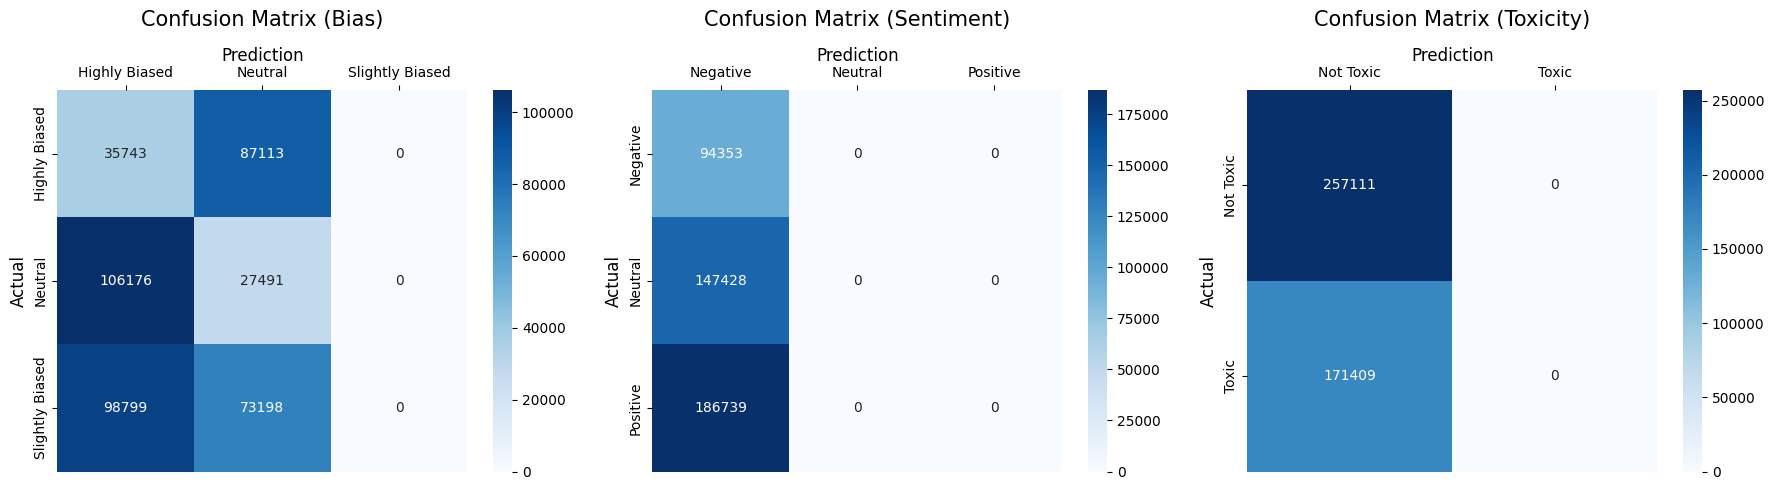

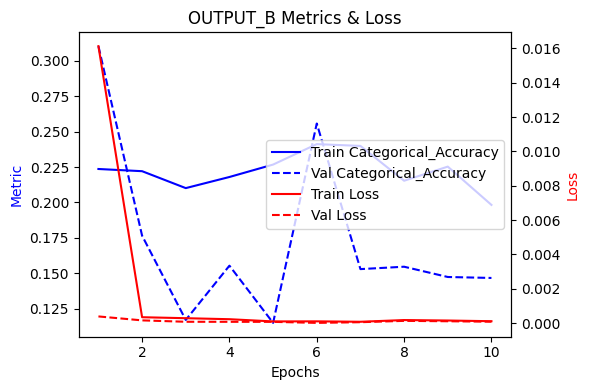

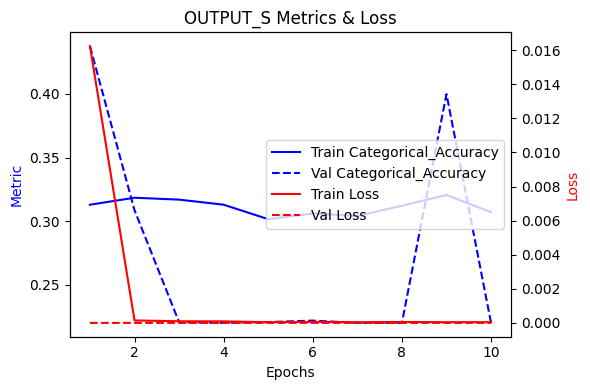

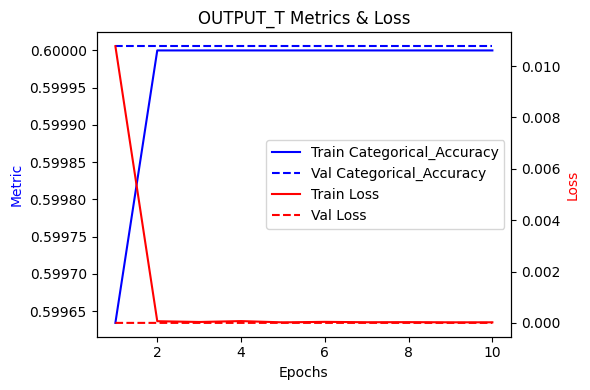


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step

Training with α=1.0, β=1.0, γ=0
====================== Bias Task ======================
Accuracy: 0.286698403808457
                 precision    recall  f1-score   support

  Highly Biased       0.29      1.00      0.45    122856
        Neutral       0.00      0.00      0.00    133667
Slightly Biased       0.00      0.00      0.00    171997

       accuracy                           0.29    428520
      macro avg       0.10      0.33      0.15    428520
   weighted avg       0.08      0.29      0.13    428520


==================== Sentiment Task ====================
Accuracy: 0.3471039858116307
              precision    recall  f1-score   support

    Negative       0.21      0.00      0.00     94353
     Neutral       0.35      0.98      0.51    147428
    Positive       0.44      0.02      0.04    186739

    accuracy                           0.35    428520
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   Not Toxic       0.55      0.54      0.55    257111
       Toxic       0.33      0.34      0.34    171409

    accuracy                           0.46    428520
   macro avg       0.44      0.44      0.44    428520
weighted avg       0.46      0.46      0.46    428520





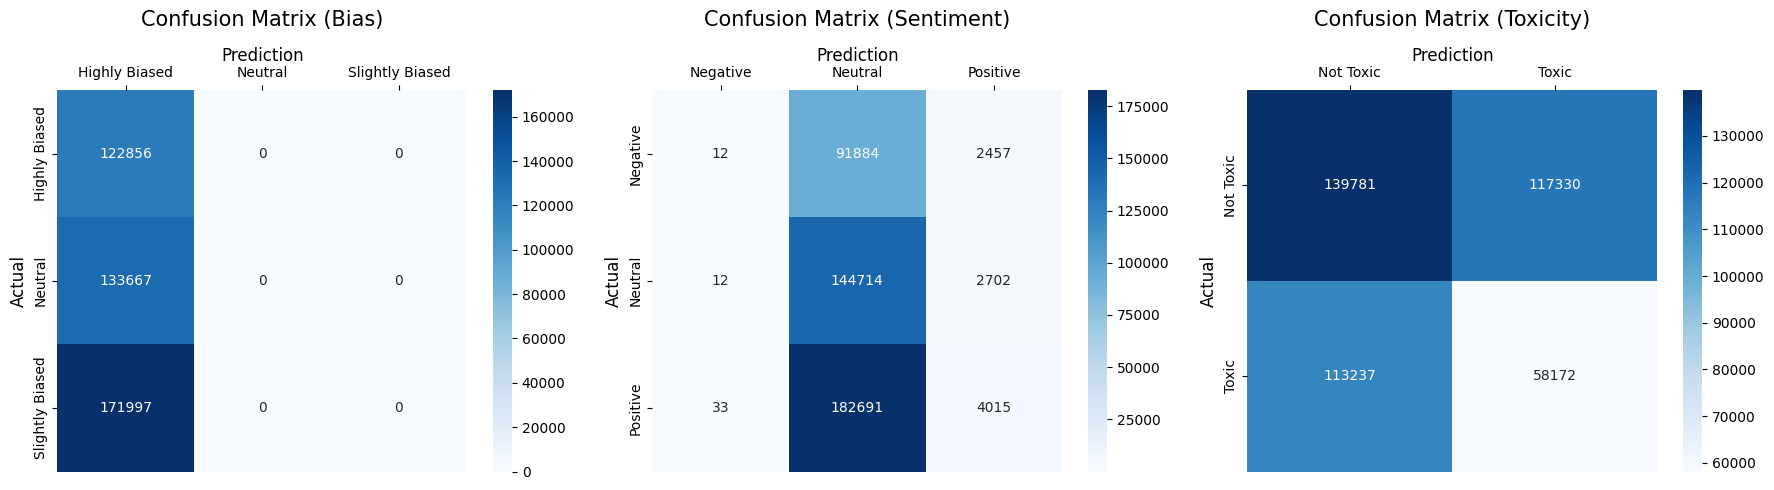

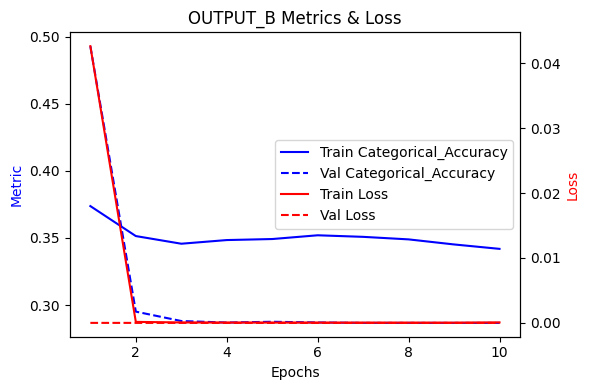

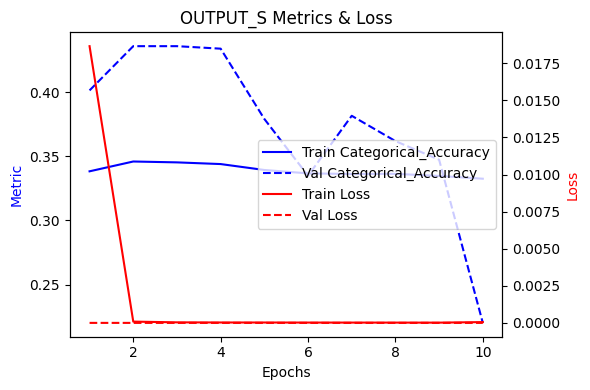

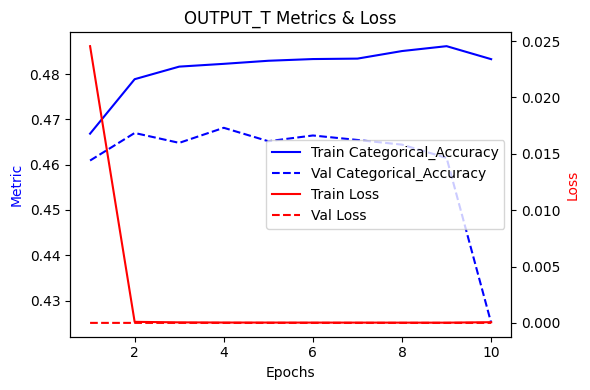


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step

Training with α=1.0, β=0, γ=1.0
====================== Bias Task ======================
Accuracy: 0.3119270979184169
                 precision    recall  f1-score   support

  Highly Biased       0.00      0.00      0.00    122856
        Neutral       0.31      1.00      0.48    133667
Slightly Biased       0.00      0.00      0.00    171997

       accuracy                           0.31    428520
      macro avg       0.10      0.33      0.16    428520
   weighted avg       0.10      0.31      0.15    428520


==================== Sentiment Task ====================
Accuracy: 0.28253757117520767
              precision    recall  f1-score   support

    Negative       0.20      0.42      0.27     94353
     Neutral       0.65      0.00      0.01    147428
    Positive       0.36      0.43      0.39    186739

    accuracy                           0.28    428520

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   Not Toxic       0.55      0.50      0.52    257111
       Toxic       0.34      0.38      0.36    171409

    accuracy                           0.45    428520
   macro avg       0.44      0.44      0.44    428520
weighted avg       0.46      0.45      0.46    428520





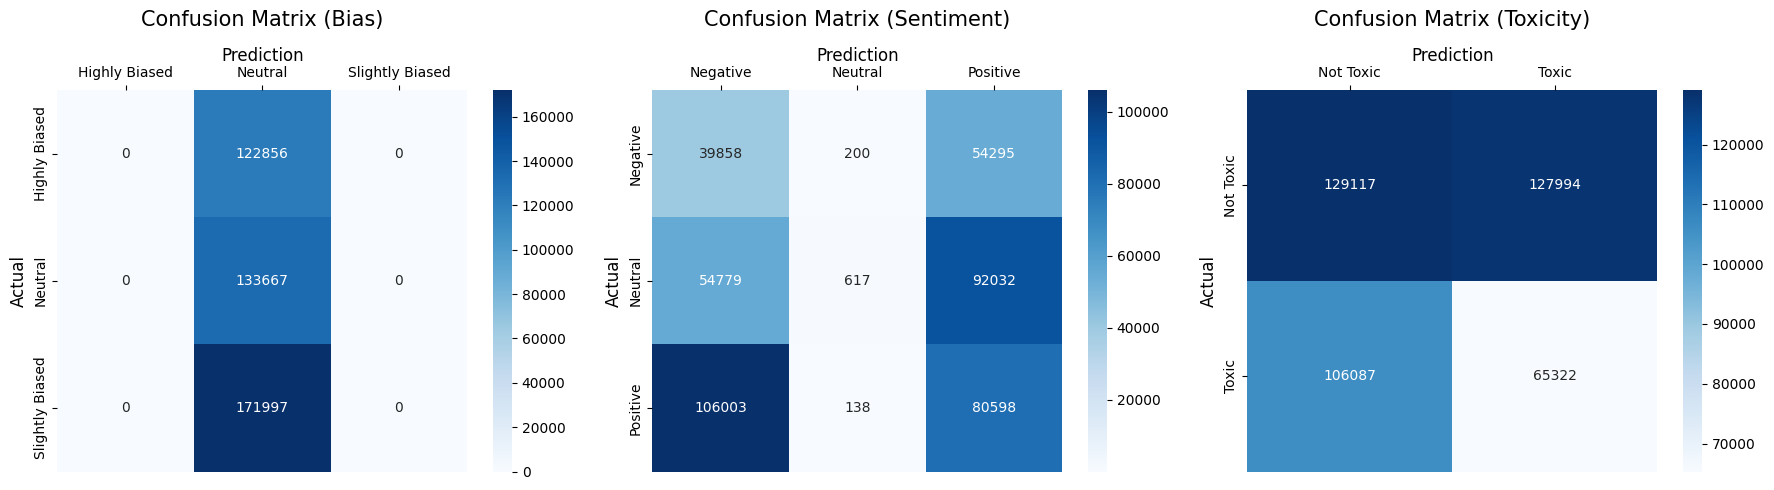

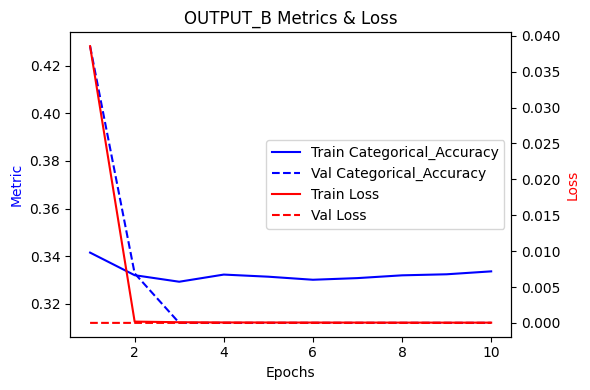

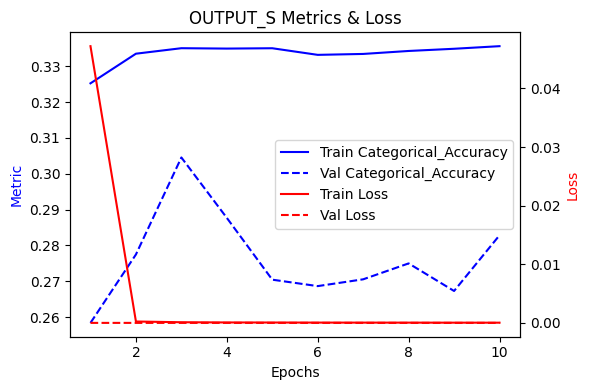

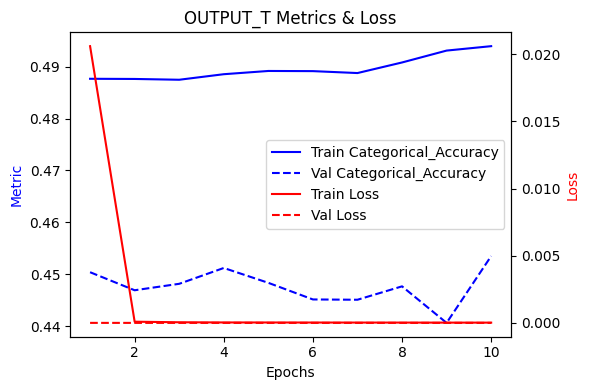


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step

Training with α=0, β=0, γ=1.0
====================== Bias Task ======================
Accuracy: 0.3119270979184169
                 precision    recall  f1-score   support

  Highly Biased       0.00      0.00      0.00    122856
        Neutral       0.31      1.00      0.48    133667
Slightly Biased       0.00      0.00      0.00    171997

       accuracy                           0.31    428520
      macro avg       0.10      0.33      0.16    428520
   weighted avg       0.10      0.31      0.15    428520


==================== Sentiment Task ====================
Accuracy: 0.22018342201064128
              precision    recall  f1-score   support

    Negative       0.22      1.00      0.36     94353
     Neutral       0.00      0.00      0.00    147428
    Positive       0.00      0.00      0.00    186739

    accuracy                           0.22    428520
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

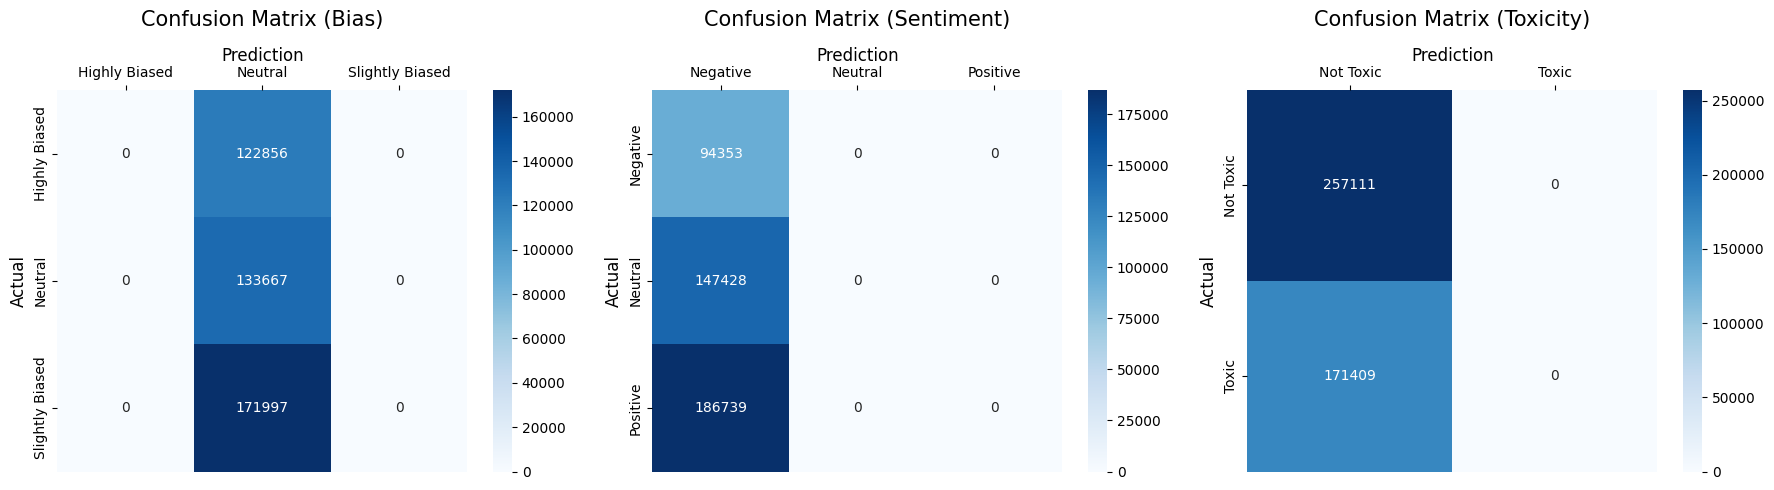

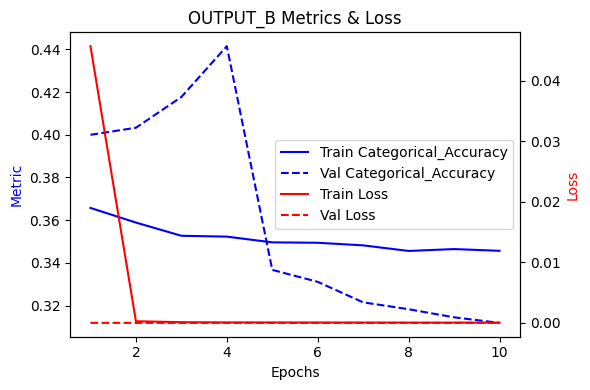

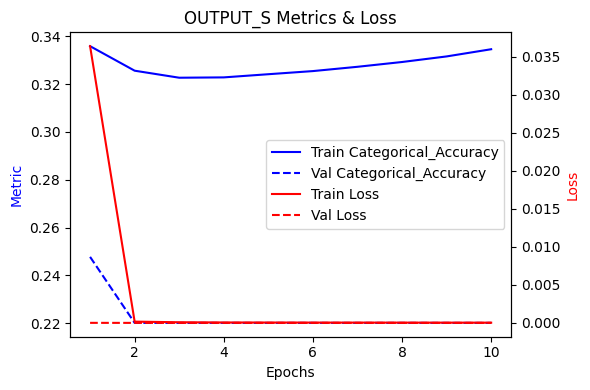

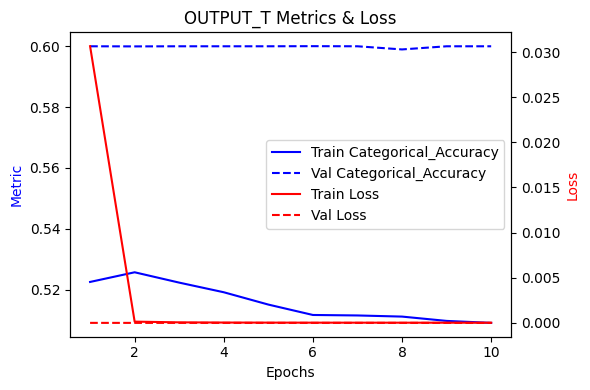


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step

Training with α=1.0, β=1.0, γ=1.0
====================== Bias Task ======================
Accuracy: 0.8666059927191263
                 precision    recall  f1-score   support

  Highly Biased       0.89      0.90      0.89    122856
        Neutral       0.88      0.88      0.88    133667
Slightly Biased       0.84      0.83      0.84    171997

       accuracy                           0.87    428520
      macro avg       0.87      0.87      0.87    428520
   weighted avg       0.87      0.87      0.87    428520


==================== Sentiment Task ====================
Accuracy: 0.9114673760851302
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87     94353
     Neutral       0.94      0.88      0.91    147428
    Positive       0.91      0.95      0.93    186739

    accuracy                           0.91    42852

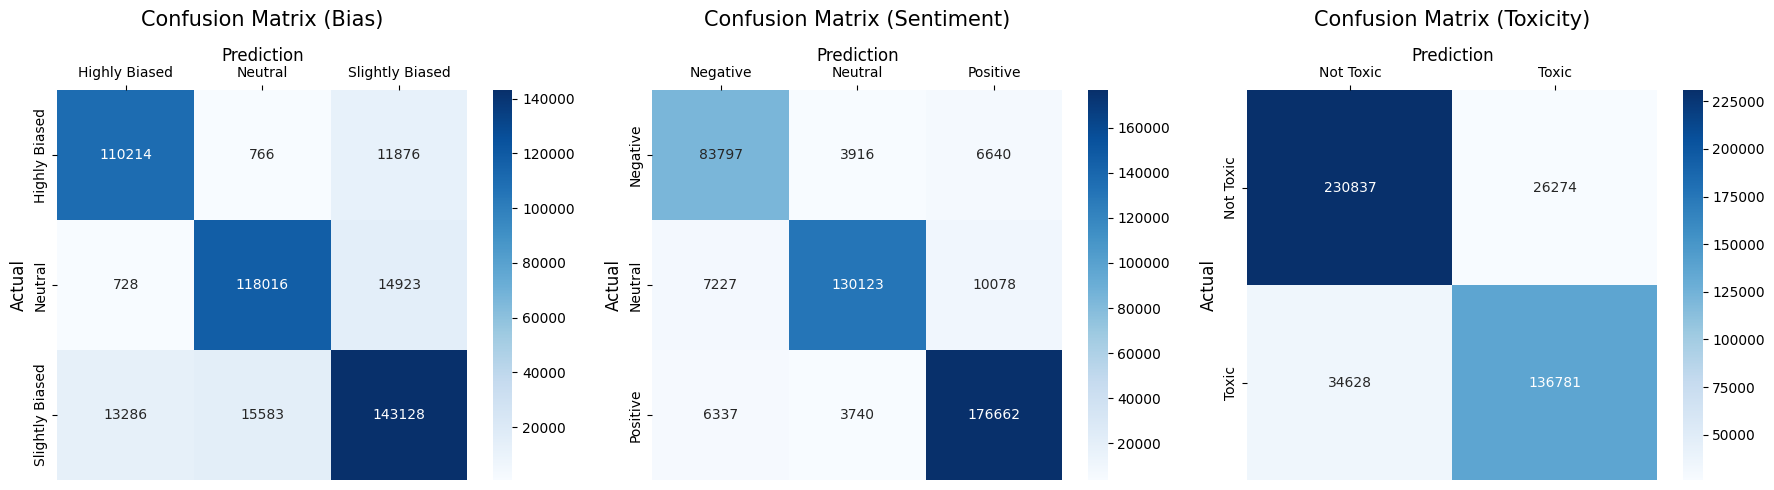

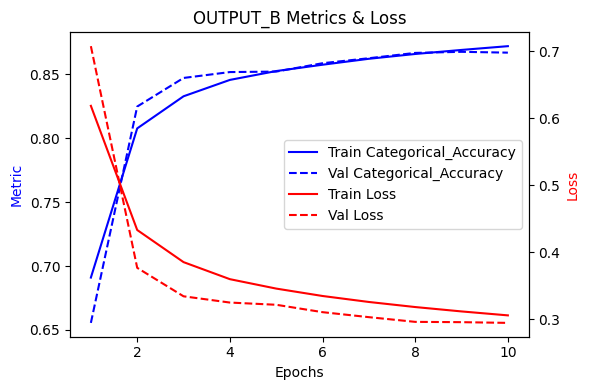

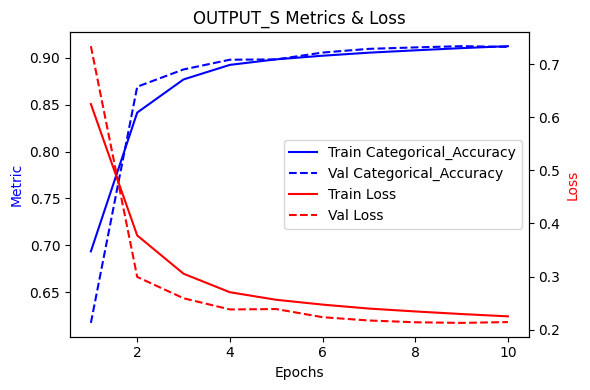

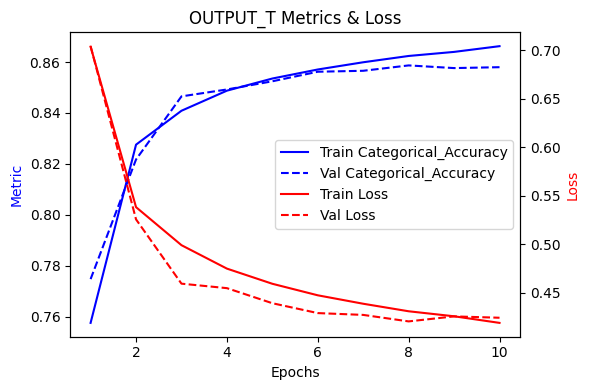


--------------------------------------------------------------------------



In [14]:
def to_int_labels(y):
    if len(y.shape) > 1 and y.shape[1] > 1:
        return np.argmax(y, axis=1)
    return y

y_test_bias_int = to_int_labels(y_test_bias)
y_test_sentiment_int = to_int_labels(y_test_sentiment)
y_test_toxic_int = to_int_labels(y_test_toxic)

for i in range(len(models_created)):
    bias_labels = ['Highly Biased', 'Neutral', 'Slightly Biased']
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    toxicity_labels = ['Not Toxic', 'Toxic']

    y_pred_probs = models_created[i].predict(X_test, batch_size=128)

    # Convert predicted probabilities to class indices
    y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
    y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
    y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

    val = combinations[i]
    print(f"\nTraining with α={val[0]}, β={val[1]}, γ={val[2]}")

    print("====================== Bias Task ======================")
    print("Accuracy:", accuracy_score(y_test_bias_int, y_pred_bias))
    print(classification_report(y_test_bias_int, y_pred_bias, target_names=bias_labels))

    print("\n==================== Sentiment Task ====================")
    print("Accuracy:", accuracy_score(y_test_sentiment_int, y_pred_sentiment))
    print(classification_report(y_test_sentiment_int, y_pred_sentiment, target_names=sentiment_labels))

    print("\n====================== Toxic Task ======================")
    print("Accuracy:", accuracy_score(y_test_toxic_int, y_pred_toxic))
    print(classification_report(y_test_toxic_int, y_pred_toxic, target_names=toxicity_labels))
    print("\n")

    def plot_cm(y_true, y_pred, labels, title, ax):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax)
        ax.set_title(title, fontsize=15, pad=15)
        ax.set_xlabel('Prediction', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    plot_cm(y_test_bias_int, y_pred_bias, ['Highly Biased', 'Neutral','Slightly Biased'], 'Confusion Matrix (Bias)', axes[0])
    plot_cm(y_test_sentiment_int, y_pred_sentiment, ['Negative', 'Neutral', 'Positive'], 'Confusion Matrix (Sentiment)', axes[1])
    plot_cm(y_test_toxic_int, y_pred_toxic, ['Not Toxic', 'Toxic'], 'Confusion Matrix (Toxicity)', axes[2])

    plt.tight_layout()
    plt.show()
    print("\n")

    def plot_history_combined(history, outputs, metrics=None):
        if metrics is None:
            metrics = []
            for key in history.history.keys():
                for output in outputs:
                    if key.startswith(output) and not key.endswith("loss"):
                        metric_name = key[len(output)+1:]  # remove output_
                        if metric_name not in metrics:
                            metrics.append(metric_name)

        epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

        for output in outputs:
            fig, ax1 = plt.subplots(figsize=(6, 4))

            ax2 = ax1.twinx()
            for metric in metrics:
                train_metric = history.history.get(f"{output}_{metric}")
                val_metric = history.history.get(f"val_{output}_{metric}")
                if train_metric and val_metric:
                    ax1.plot(epochs, train_metric, "b-", label=f"Train {metric.title()}")
                    ax1.plot(epochs, val_metric, "b--", label=f"Val {metric.title()}")

            train_loss = history.history.get(f"{output}_loss")
            val_loss = history.history.get(f"val_{output}_loss")
            if train_loss and val_loss:
                ax2.plot(epochs, train_loss, "r-", label="Train Loss")
                ax2.plot(epochs, val_loss, "r--", label="Val Loss")

            ax1.set_xlabel("Epochs")
            ax1.set_ylabel("Metric", color="b")
            ax2.set_ylabel("Loss", color="r")
            ax1.set_title(f"{output.upper()} Metrics & Loss")

            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

            plt.tight_layout()
            plt.show()

    outputs = ["output_b", "output_s", "output_t"]
    plot_history_combined(history_created[i], outputs)

    print("\n--------------------------------------------------------------------------\n")



##### 10. Additional Ablations

In [16]:
combinations = [
    (0, 1.0, 0), # F Only
    (0, 1.0, 1.0), # I & F
]

In [17]:
results = []
flag = 0
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
models_created = []
history_created = []

for alpha, beta, gamma in combinations:
    print(f"\nTraining with α={alpha}, β={beta}, γ={gamma}")
    model = build_model(alpha, beta, gamma)
    history = model.fit(
        X_train,
        {
            "output_b": y_train_bias_oh,
            "output_s": y_train_sentiment_oh,
            "output_t": y_train_toxic_oh
        },
        validation_data=(
            X_valid,
            {
                "output_b": y_valid_bias_oh,
                "output_s": y_valid_sentiment_oh,
                "output_t": y_valid_toxic_oh
            }
        ),
        epochs=10,
        batch_size=8192,
        verbose=1,
        callbacks=[early_stopping]
    )

    acc_b = history.history['val_output_b_categorical_accuracy'][-1]
    acc_s = history.history['val_output_s_categorical_accuracy'][-1]
    acc_t = history.history['val_output_t_categorical_accuracy'][-1]

    results.append({
        "alpha": alpha,
        "beta": beta,
        "gamma": gamma,
        "bias_val_acc": acc_b,
        "sentiment_val_acc": acc_s,
        "toxic_val_acc": acc_t
    })
    models_created.append(model)
    history_created.append(history)


Training with α=0, β=1.0, γ=0
Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 184s 734ms/step - loss: 0.3669 - output_b_categorical_accuracy: 0.3852 - output_b_loss: 0.1275 - output_s_categorical_accuracy: 0.3351 - output_s_loss: 0.1267 - output_t_categorical_accuracy: 0.4715 - output_t_loss: 0.0953 - val_loss: 0.0161 - val_output_b_categorical_accuracy: 0.4208 - val_output_b_loss: 2.1450e-06 - val_output_s_categorical_accuracy: 0.3416 - val_output_s_loss: 4.5590e-07 - val_output_t_categorical_accuracy: 0.4141 - val_output_t_loss: 3.5166e-07
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 189s 770ms/step - loss: 0.0157 - output_b_categorical_accuracy: 0.3884 - output_b_loss: 1.8878e-04 - output_s_categorical_accuracy: 0.3409 - output_s_loss: 1.4737e-04 - output_t_categorical_accuracy: 0.4908 - output_t_loss: 7.6777e-05 - val_loss: 0.0129 - val_output_b_categorical_accuracy: 0.4150 - val_output_b_loss: 1.5996e-07 - val_output_s_categorical_accuracy: 0.3462 - val_output_s_loss: 1.5900e-07 - val_output_

In [18]:
models_created[0].summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 100, 128)  │  1,280,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256)       │    263,168 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ bidirectional_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      4,160 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,694,937 (17.91 MB)

 Trainable params: 1,564,808 (5.97 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 3,129,617 (11.94 MB)

In [19]:
results_df = pd.DataFrame(results)
print("\nValidation accuracy summary:")
print(results_df)


Validation accuracy summary:
   alpha  beta  gamma  bias_val_acc  sentiment_val_acc  toxic_val_acc
0      0   1.0    0.0      0.401376           0.343344       0.399994
1      0   1.0    1.0      0.870501           0.913913       0.861440


3348/3348 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step

Training with α=0, β=1.0, γ=0
====================== Bias Task ======================
Accuracy: 0.4013744982731261
                 precision    recall  f1-score   support

  Highly Biased       0.00      0.00      0.00    122856
        Neutral       0.00      0.00      0.00    133667
Slightly Biased       0.40      1.00      0.57    171997

       accuracy                           0.40    428520
      macro avg       0.13      0.33      0.19    428520
   weighted avg       0.16      0.40      0.23    428520


==================== Sentiment Task ====================
Accuracy: 0.343405208625035
              precision    recall  f1-score   support

    Negative       0.14      0.00      0.01     94353
     Neutral       0.34      1.00      0.51    147428
    Positive       0.00      0.00      0.00    186739

    accuracy                           0.34    428520
   macro avg       0.16      0.33      0.17    428520
weighted avg       0.15   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

              precision    recall  f1-score   support

   Not Toxic       0.00      0.00      0.00    257111
       Toxic       0.40      1.00      0.57    171409

    accuracy                           0.40    428520
   macro avg       0.20      0.50      0.29    428520
weighted avg       0.16      0.40      0.23    428520





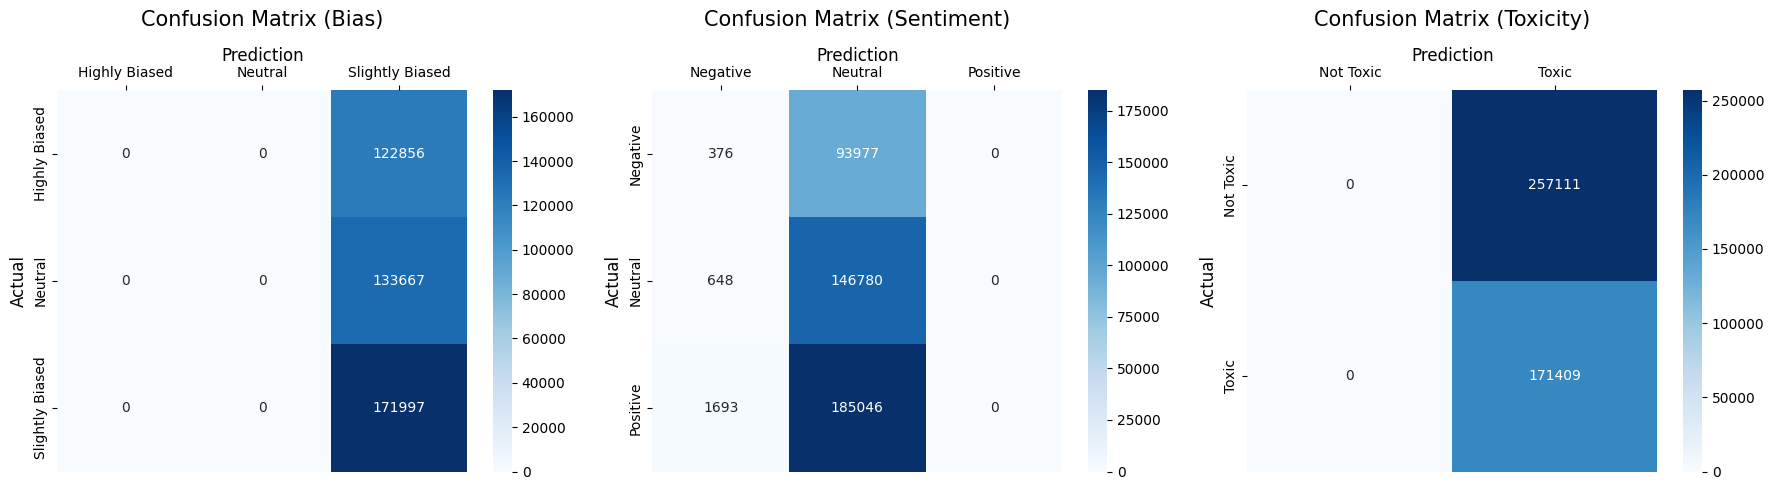

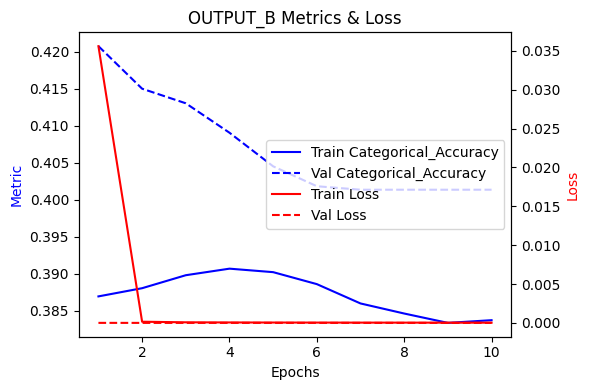

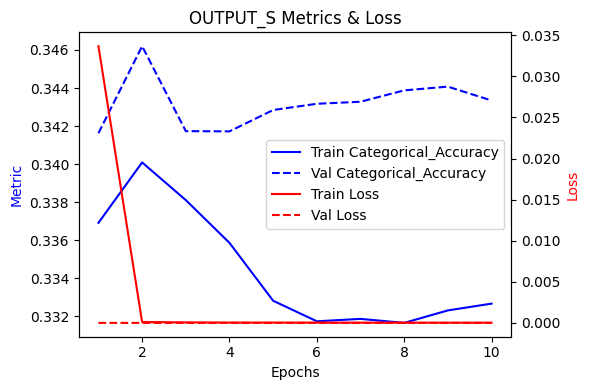

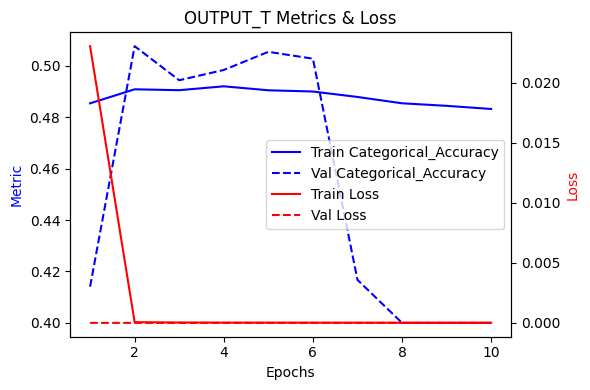


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step

Training with α=0, β=1.0, γ=1.0
====================== Bias Task ======================
Accuracy: 0.8700387379818911
                 precision    recall  f1-score   support

  Highly Biased       0.88      0.91      0.90    122856
        Neutral       0.87      0.89      0.88    133667
Slightly Biased       0.86      0.82      0.84    171997

       accuracy                           0.87    428520
      macro avg       0.87      0.88      0.87    428520
   weighted avg       0.87      0.87      0.87    428520


==================== Sentiment Task ====================
Accuracy: 0.9140413516288621
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87     94353
     Neutral       0.94      0.89      0.92    147428
    Positive       0.92      0.94      0.93    186739

    accuracy                           0.91    428520


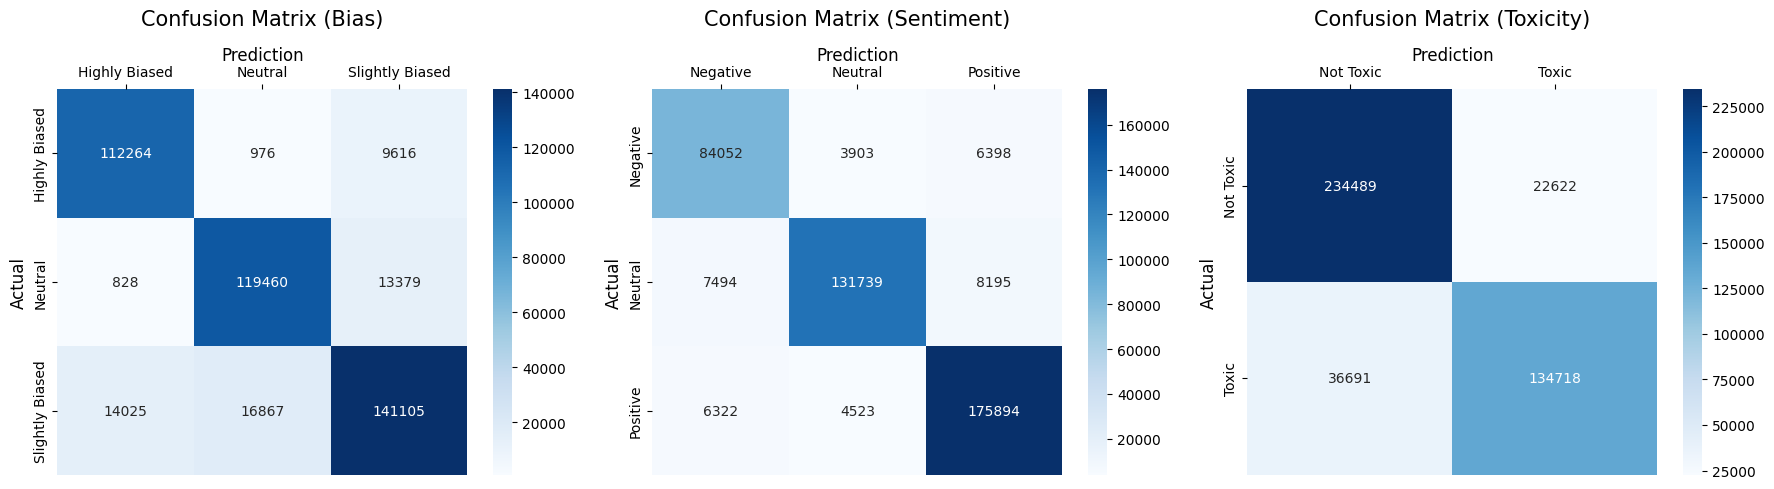

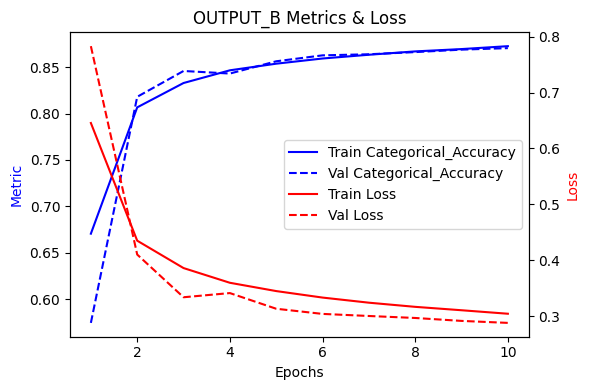

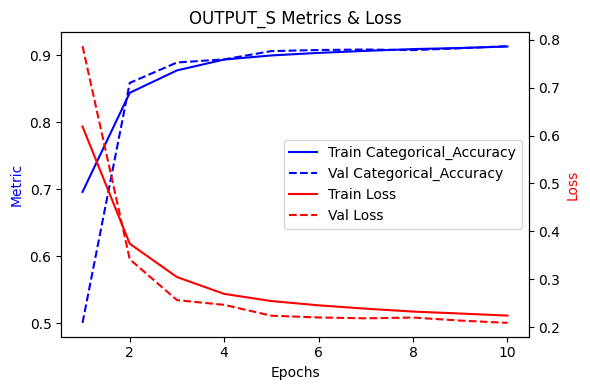

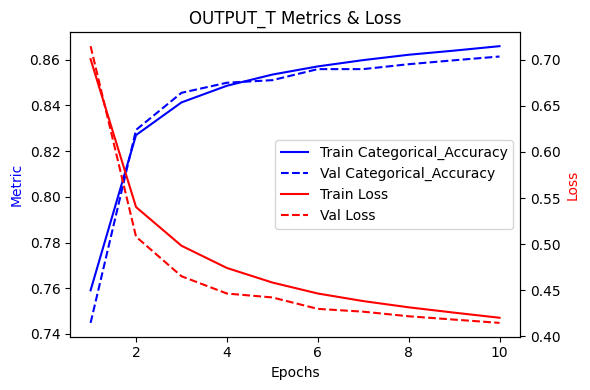


--------------------------------------------------------------------------



In [20]:
def to_int_labels(y):
    if len(y.shape) > 1 and y.shape[1] > 1:
        return np.argmax(y, axis=1)
    return y

y_test_bias_int = to_int_labels(y_test_bias)
y_test_sentiment_int = to_int_labels(y_test_sentiment)
y_test_toxic_int = to_int_labels(y_test_toxic)

for i in range(len(models_created)):
    bias_labels = ['Highly Biased', 'Neutral', 'Slightly Biased']
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    toxicity_labels = ['Not Toxic', 'Toxic']

    y_pred_probs = models_created[i].predict(X_test, batch_size=128)

    # Convert predicted probabilities to class indices
    y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
    y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
    y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

    val = combinations[i]
    print(f"\nTraining with α={val[0]}, β={val[1]}, γ={val[2]}")

    print("====================== Bias Task ======================")
    print("Accuracy:", accuracy_score(y_test_bias_int, y_pred_bias))
    print(classification_report(y_test_bias_int, y_pred_bias, target_names=bias_labels))

    print("\n==================== Sentiment Task ====================")
    print("Accuracy:", accuracy_score(y_test_sentiment_int, y_pred_sentiment))
    print(classification_report(y_test_sentiment_int, y_pred_sentiment, target_names=sentiment_labels))

    print("\n====================== Toxic Task ======================")
    print("Accuracy:", accuracy_score(y_test_toxic_int, y_pred_toxic))
    print(classification_report(y_test_toxic_int, y_pred_toxic, target_names=toxicity_labels))
    print("\n")

    def plot_cm(y_true, y_pred, labels, title, ax):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax)
        ax.set_title(title, fontsize=15, pad=15)
        ax.set_xlabel('Prediction', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    plot_cm(y_test_bias_int, y_pred_bias, ['Highly Biased', 'Neutral','Slightly Biased'], 'Confusion Matrix (Bias)', axes[0])
    plot_cm(y_test_sentiment_int, y_pred_sentiment, ['Negative', 'Neutral', 'Positive'], 'Confusion Matrix (Sentiment)', axes[1])
    plot_cm(y_test_toxic_int, y_pred_toxic, ['Not Toxic', 'Toxic'], 'Confusion Matrix (Toxicity)', axes[2])

    plt.tight_layout()
    plt.show()
    print("\n")

    def plot_history_combined(history, outputs, metrics=None):
        if metrics is None:
            metrics = []
            for key in history.history.keys():
                for output in outputs:
                    if key.startswith(output) and not key.endswith("loss"):
                        metric_name = key[len(output)+1:]  # remove output_
                        if metric_name not in metrics:
                            metrics.append(metric_name)

        epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

        for output in outputs:
            fig, ax1 = plt.subplots(figsize=(6, 4))

            ax2 = ax1.twinx()
            for metric in metrics:
                train_metric = history.history.get(f"{output}_{metric}")
                val_metric = history.history.get(f"val_{output}_{metric}")
                if train_metric and val_metric:
                    ax1.plot(epochs, train_metric, "b-", label=f"Train {metric.title()}")
                    ax1.plot(epochs, val_metric, "b--", label=f"Val {metric.title()}")

            train_loss = history.history.get(f"{output}_loss")
            val_loss = history.history.get(f"val_{output}_loss")
            if train_loss and val_loss:
                ax2.plot(epochs, train_loss, "r-", label="Train Loss")
                ax2.plot(epochs, val_loss, "r--", label="Val Loss")

            ax1.set_xlabel("Epochs")
            ax1.set_ylabel("Metric", color="b")
            ax2.set_ylabel("Loss", color="r")
            ax1.set_title(f"{output.upper()} Metrics & Loss")

            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

            plt.tight_layout()
            plt.show()

    outputs = ["output_b", "output_s", "output_t"]
    plot_history_combined(history_created[i], outputs)

    print("\n--------------------------------------------------------------------------\n")

